In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn # For nice looking plots.

import numpy as np
import scipy as sp
import scipy.io

import os
import copy
import time
import datetime

import tensorflow as tf

import sklearn
import sklearn.ensemble
import sklearn.preprocessing

np.set_printoptions(precision=2, suppress=True, linewidth=140)

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [28]:
# Load the training and test data
sarcos_inv = scipy.io.loadmat('../data/sarcos_inv.mat')['sarcos_inv']
sarcos_inv_test = scipy.io.loadmat('../data/sarcos_inv_test.mat')['sarcos_inv_test']

def split_data(data, timesteps=1):
    X, Y = np.split(data, [21], axis=1)
    
    if timesteps == 1:
        return X, Y
    
    Xres = np.zeros((X.shape[0] - timesteps + 1, 7 * timesteps))
    Yres = Y[timesteps - 1:]
    
    for i in xrange(X.shape[0] - timesteps + 1):
        Xres[i] = np.reshape(X[i:i+timesteps], -1)
    
    return Xres, Yres


# Train random forest with different tree depth and n_estimators

In [29]:
# Training with different tree depth

params = []
for n_estimators in [5, 10, 15, 20]:
    for max_depth in [5, 10, 15, 20, 25, 30]:
        params.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'n_jobs': 7
        })

for param in params:
    print 'Training for:', param
    rf = sklearn.ensemble.RandomForestRegressor(**param)
    rf.fit(*split_data(sarcos_inv))

    Xts, Yts = split_data(sarcos_inv_test)
    Ypred = rf.predict(Xts)

    param['l2_loss'] = sklearn.metrics.mean_squared_error(Yts, Ypred)
    
print 'done'

Training for: {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 5}
Training for: {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 10}
Training for: {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 15}
Training for: {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 20}
Training for: {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 25}
Training for: {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 30}
Training for: {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 5}
Training for: {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 10}
Training for: {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 15}
Training for: {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 20}
Training for: {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 25}
Training for: {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 30}
Training for: {'n_estimators': 15, 'n_jobs': 7, 'max_depth': 5}
Training for: {'n_estimators': 15, 'n_jobs': 7, 'max_depth': 10}
Training for: {'n_estimators': 15, 'n_jobs': 7, 'max_depth': 15}
Training for: {'n_estimators': 15,

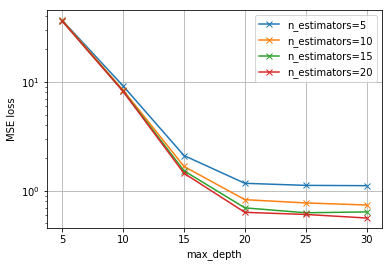

In [30]:
for n_estimators in np.unique([p['n_estimators'] for p in params]):
    pars = [p for p in params if p['n_estimators'] == n_estimators]
    x = [p['max_depth'] for p in pars]
    y = [p['l2_loss'] for p in pars]

    plt.semilogy(x, y, 'x-', label="n_estimators=%d" % (n_estimators))
    
plt.xlabel('max_depth')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()

# Train random forest over many history steps

In [48]:
# Training with different tree depth

params = []
for history_steps in [1, 3, 5]:
    for n_estimators in [5, 10, 15, 20]:
        for max_depth in [5, 10, 15, 20, 25, 30]:
            params.append({
                'model': {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'n_jobs': 7
                },
                'history_steps': history_steps
            })

for param in params:
    print 'Training for:', param
    rf = sklearn.ensemble.RandomForestRegressor(**param['model'])
    rf.fit(*split_data(sarcos_inv, history_steps))

    Xts, Yts = split_data(sarcos_inv_test, param['history_steps'])
    Ypred = rf.predict(Xts)

    param['l2_loss'] = sklearn.metrics.mean_squared_error(Yts, Ypred)

print 'done'

Training for: {'history_steps': 1, 'model': {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 5}}
Training for: {'history_steps': 1, 'model': {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 10}}
Training for: {'history_steps': 1, 'model': {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 15}}
Training for: {'history_steps': 1, 'model': {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 20}}
Training for: {'history_steps': 1, 'model': {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 25}}
Training for: {'history_steps': 1, 'model': {'n_estimators': 5, 'n_jobs': 7, 'max_depth': 30}}
Training for: {'history_steps': 1, 'model': {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 5}}
Training for: {'history_steps': 1, 'model': {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 10}}
Training for: {'history_steps': 1, 'model': {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 15}}
Training for: {'history_steps': 1, 'model': {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 20}}
Training for: {'history_steps': 1, 'model': {'n_

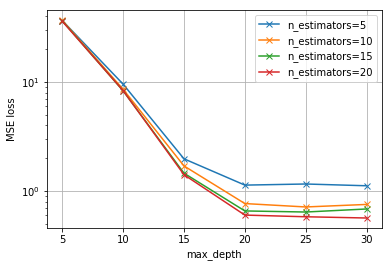

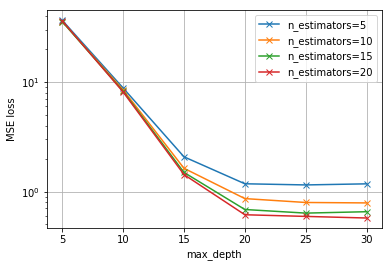

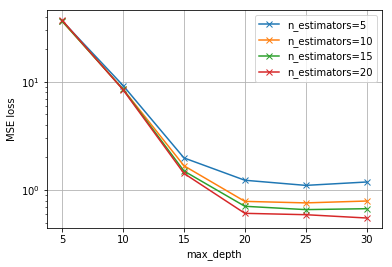

In [50]:
for history_steps in np.unique([p['history_steps'] for p in params]):
    for n_estimators in np.unique([p['model']['n_estimators'] for p in params]):
        pars = [p for p in params if p['model']['n_estimators'] == n_estimators and p['history_steps'] == history_steps]
        x = [p['model']['max_depth'] for p in pars]
        y = [p['l2_loss'] for p in pars]

        plt.semilogy(x, y, 'x-', label="n_estimators=%d" % (n_estimators))

    
    plt.xlabel('max_depth')
    plt.ylabel('MSE loss')
    plt.grid()
    plt.legend()
    plt.show()
